## Import Libraries

In [58]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import berserk # Lichess API

## Data Acquisition

In [59]:
session = berserk.TokenSession('lip_5EdJyO3nGHYPS81gdLNv')
client = berserk.Client(session=session)

In [60]:
games_white = []
games_black = []

"""  List of featured and community Lichess bots """

bots = ['LeelaChess', 
        'LeelaNice', 
        'LeelaRogue',
        'LeelaLevel5', 
        'maia1', 
        'maia5', 
        'maia9',
        'Boris-Trapsky',
        'simpleEval',
        'zeekat',
        'eubos',
        'halcyonbot',
        'sargon-1ply',
        'humanian',
        'humaia'
        ]

""" Export bot games (white pieces) """

for bot in bots:
    games_white.extend(list(client.games.export_by_player(bot, 
                                                    max=100, 
                                                    color="white",
                                                    rated=True,
                                                    evals=True,
                                                    analysed=True)))

""" Export bot games (black pieces) """

for bot in bots:
    games_black.extend(list(client.games.export_by_player(bot, 
                                                    max=100, 
                                                    color="black",
                                                    rated=True,
                                                    evals=True,
                                                    analysed=True)))
len(games_white), len(games_black)

(1456, 1462)

## Exploratory Data Analysis

In [61]:
""" Extract relevant features and store in dictionary.  """

D = {
    'id': [],
    'variant': [],
    'speed': [],
    'perf': [],
    'status': [],
    'white_id': [],
    'black_id': [],
    'bot_id': [],
    'winner': [],
    'player_win': [],
    'moves': [],
    'clock': [],
    'player_rating': [],
    'player_rating_diff': [],
    'player_inaccuracies': [],
    'player_mistakes': [],
    'player_blunders': [],
    'player_acpl': [],
    'bot_rating': [],
    'bot_rating_diff': [],
    'bot_inaccuracies': [],
    'bot_mistakes': [],
    'bot_blunders': [],
    'bot_acpl': []
}

for game in games_white:

    if game['speed'] == "correspondence" or game['perf'] == "correspondence":
        continue

    D['id'].append(game['id'])
    D['variant'].append(game['variant'])
    D['speed'].append(game['speed'])
    D['perf'].append(game['perf'])
    D['status'].append(game['status'])

    D['bot_id'].append(game['players']['white']['user']['id'])
    D['white_id'].append(game['players']['white']['user']['id'])
    D['black_id'].append(game['players']['black']['user']['id'])


    try:
        D['bot_rating_diff'].append(game['players']['white']['ratingDiff'])
        D['player_rating_diff'].append(game['players']['black']['ratingDiff'])

    except KeyError:
        D['bot_rating_diff'].append(0)
        D['player_rating_diff'].append(0)

    D['bot_rating'].append(game['players']['white']['rating'])
    D['bot_inaccuracies'].append(game['players']['white']['analysis']['inaccuracy'])
    D['bot_mistakes'].append(game['players']['white']['analysis']['mistake'])
    D['bot_blunders'].append(game['players']['white']['analysis']['blunder'])
    D['bot_acpl'].append(game['players']['white']['analysis']['acpl'])

    D['player_rating'].append(game['players']['black']['rating'])
    D['player_inaccuracies'].append(game['players']['black']['analysis']['inaccuracy'])
    D['player_mistakes'].append(game['players']['black']['analysis']['mistake'])
    D['player_blunders'].append(game['players']['black']['analysis']['blunder'])
    D['player_acpl'].append(game['players']['black']['analysis']['acpl'])

    D['moves'].append(np.ceil(len(game['moves'].split(" ")) / 2))
    D['clock'].append(game['clock']['initial'])

    try:
        if game['winner'] == 'white':
            D['winner'].append(1)
            D['player_win'].append(0)

        elif game['winner'] == 'black':
            D['winner'].append(0)
            D['player_win'].append(1)
        
    except KeyError:
        D['winner'].append(0.5)
        D['player_win'].append(0.5)


for game in games_black:
    
    if game['speed'] == "correspondence" or game['perf'] == "correspondence":
        continue

    D['id'].append(game['id'])
    D['variant'].append(game['variant'])
    D['speed'].append(game['speed'])
    D['perf'].append(game['perf'])
    D['status'].append(game['status'])

    D['bot_id'].append(game['players']['black']['user']['id'])
    D['white_id'].append(game['players']['white']['user']['id'])
    D['black_id'].append(game['players']['black']['user']['id'])


    try:
        D['player_rating_diff'].append(game['players']['white']['ratingDiff'])
        D['bot_rating_diff'].append(game['players']['black']['ratingDiff'])

    except KeyError:
        D['player_rating_diff'].append(0)
        D['bot_rating_diff'].append(0)

    D['player_rating'].append(game['players']['white']['rating'])
    D['player_inaccuracies'].append(game['players']['white']['analysis']['inaccuracy'])
    D['player_mistakes'].append(game['players']['white']['analysis']['mistake'])
    D['player_blunders'].append(game['players']['white']['analysis']['blunder'])
    D['player_acpl'].append(game['players']['white']['analysis']['acpl'])

    D['bot_rating'].append(game['players']['black']['rating'])
    D['bot_inaccuracies'].append(game['players']['black']['analysis']['inaccuracy'])
    D['bot_mistakes'].append(game['players']['black']['analysis']['mistake'])
    D['bot_blunders'].append(game['players']['black']['analysis']['blunder'])
    D['bot_acpl'].append(game['players']['black']['analysis']['acpl'])

    D['moves'].append(np.ceil(len(game['moves'].split(" ")) / 2))
    D['clock'].append(game['clock']['initial'])


    try:
        if game['winner'] == 'white':
            D['winner'].append(1)
            D['player_win'].append(1)

        elif game['winner'] == 'black':
            D['winner'].append(0)
            D['player_win'].append(0)
        
    except KeyError:
        D['winner'].append(0.5)
        D['player_win'].append(0.5)

In [62]:
""" Create DataFrame from feature dictionary and save it as .csv """
df = pd.DataFrame(data=D)
df.to_csv('games.csv')

# """ If dataset already saved to .csv """

# df = pd.read_csv('games.csv')
# df = df.sample(frac=1).reset_index(drop=True)

In [63]:
df.groupby(['bot_id']).size()

bot_id
boris-trapsky    200
eubos            200
halcyonbot       126
humaia           200
humanian         192
leelachess       200
leelalevel5      200
leelanice        200
leelarogue       200
maia1            200
maia5            200
maia9            200
sargon-1ply      200
simpleeval       200
zeekat           180
dtype: int64

In [64]:
df.head(10)

,id,variant,speed,perf,status,white_id,black_id,bot_id,winner,player_win,...,player_inaccuracies,player_mistakes,player_blunders,player_acpl,bot_rating,bot_rating_diff,bot_inaccuracies,bot_mistakes,bot_blunders,bot_acpl
0,4C7npxXQ,standard,blitz,blitz,resign,leelachess,olegelevator,leelachess,1.0,0.0,...,1,1,1,43,2656,1,0,0,0,10
1,gQzHzNWp,standard,blitz,blitz,resign,leelachess,olegelevator,leelachess,1.0,0.0,...,1,0,2,66,2655,1,1,0,0,13
2,8v5TqSH3,standard,bullet,bullet,resign,leelachess,allangabrielhilario,leelachess,1.0,0.0,...,2,3,0,121,2600,1,1,0,0,38
3,2PTJMyOw,standard,rapid,rapid,resign,leelachess,alqidiys,leelachess,1.0,0.0,...,2,0,0,23,2490,3,0,0,0,9
4,BfqS3v7H,standard,rapid,rapid,resign,leelachess,alqidiys,leelachess,1.0,0.0,...,1,0,1,47,2483,4,0,0,0,7
5,3LnvgZHN,standard,rapid,rapid,resign,leelachess,alqidiys,leelachess,1.0,0.0,...,3,0,0,29,2475,4,0,0,0,9
6,FVhrojs4,standard,rapid,rapid,resign,leelachess,yajatvp,leelachess,1.0,0.0,...,1,2,0,47,2471,0,0,0,0,9
7,4yoUPhDy,standard,bullet,bullet,mate,leelachess,p_paradox,leelachess,1.0,0.0,...,1,1,1,42,2599,0,0,0,0,10
8,Nqw9jNhj,standard,blitz,blitz,resign,leelachess,alliestain,leelachess,1.0,0.0,...,4,0,2,53,2652,1,1,0,0,29
9,Oyn6e58w,standard,blitz,blitz,resign,leelachess,alliestain,leelachess,1.0,0.0,...,1,1,0,21,2650,1,0,0,0,12


In [65]:
""" Drop unnecessary features and discard irrelevant data """

# df = df.drop(columns=['Unnamed: 0'])
df = df[df['moves'] >= 15]
df = df[df['clock'] >= 60]
df = df[df['variant'] == "standard"]
# df = df[df['bot_id'] != "leelachess"]

df.groupby(['bot_id']).size()


bot_id
boris-trapsky    192
eubos            192
halcyonbot       123
humaia           196
humanian         173
leelachess       143
leelalevel5      168
leelanice        175
leelarogue       196
maia1            183
maia5            196
maia9            195
sargon-1ply      189
simpleeval       184
zeekat           167
dtype: int64

In [91]:
avg_player_rating = df["player_rating"].mean()
print(f"Average Player Rating: {avg_player_rating}")

avg_bot_rating = df["bot_rating"].mean()
print(f"Average Bot Rating: {avg_bot_rating}")

Average Player Rating: 1795.059131736527
Average Bot Rating: 1902.9603293413174


Distribution of time controls


<AxesSubplot:xlabel='perf', ylabel='count'>

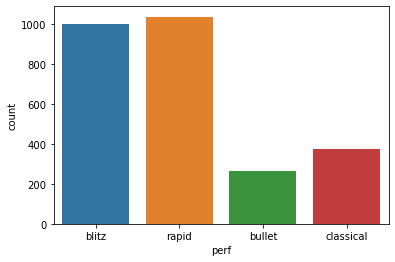

In [89]:
print("Distribution of time controls")
sns.countplot(x=df["perf"])

Distribution of game outcomes


<AxesSubplot:xlabel='status', ylabel='count'>

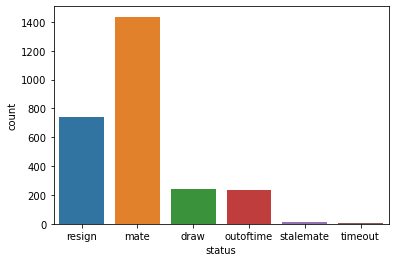

In [92]:
print("Distribution of game outcomes")
sns.countplot(x=df["status"])

In [66]:
df.head(10)

,id,variant,speed,perf,status,white_id,black_id,bot_id,winner,player_win,...,player_inaccuracies,player_mistakes,player_blunders,player_acpl,bot_rating,bot_rating_diff,bot_inaccuracies,bot_mistakes,bot_blunders,bot_acpl
0,4C7npxXQ,standard,blitz,blitz,resign,leelachess,olegelevator,leelachess,1.0,0.0,...,1,1,1,43,2656,1,0,0,0,10
1,gQzHzNWp,standard,blitz,blitz,resign,leelachess,olegelevator,leelachess,1.0,0.0,...,1,0,2,66,2655,1,1,0,0,13
3,2PTJMyOw,standard,rapid,rapid,resign,leelachess,alqidiys,leelachess,1.0,0.0,...,2,0,0,23,2490,3,0,0,0,9
5,3LnvgZHN,standard,rapid,rapid,resign,leelachess,alqidiys,leelachess,1.0,0.0,...,3,0,0,29,2475,4,0,0,0,9
6,FVhrojs4,standard,rapid,rapid,resign,leelachess,yajatvp,leelachess,1.0,0.0,...,1,2,0,47,2471,0,0,0,0,9
7,4yoUPhDy,standard,bullet,bullet,mate,leelachess,p_paradox,leelachess,1.0,0.0,...,1,1,1,42,2599,0,0,0,0,10
8,Nqw9jNhj,standard,blitz,blitz,resign,leelachess,alliestain,leelachess,1.0,0.0,...,4,0,2,53,2652,1,1,0,0,29
9,Oyn6e58w,standard,blitz,blitz,resign,leelachess,alliestain,leelachess,1.0,0.0,...,1,1,0,21,2650,1,0,0,0,12
13,5Z1OOFXt,standard,blitz,blitz,resign,leelachess,vedant926,leelachess,1.0,0.0,...,0,1,1,57,2649,1,0,0,0,3
15,irRhJ7ad,standard,rapid,rapid,resign,leelachess,alqidiys,leelachess,1.0,0.0,...,3,0,0,51,2466,4,0,0,0,17


In [67]:
""" Check For Missing Values """

df.isna().sum()

id                     0
variant                0
speed                  0
perf                   0
status                 0
white_id               0
black_id               0
bot_id                 0
winner                 0
player_win             0
moves                  0
clock                  0
player_rating          0
player_rating_diff     0
player_inaccuracies    0
player_mistakes        0
player_blunders        0
player_acpl            0
bot_rating             0
bot_rating_diff        0
bot_inaccuracies       0
bot_mistakes           0
bot_blunders           0
bot_acpl               0
dtype: int64

In [68]:
""" Compute Pair-Wise Correlations """
    
print(df.corr(method='pearson')['bot_rating'].sort_values())


bot_acpl              -0.549193
bot_blunders          -0.499797
player_blunders       -0.313549
player_acpl           -0.310210
player_win            -0.278243
bot_mistakes          -0.272586
clock                 -0.251449
bot_inaccuracies      -0.180921
player_mistakes       -0.134469
player_inaccuracies   -0.085479
winner                -0.032944
bot_rating_diff        0.024306
player_rating_diff     0.077525
moves                  0.133105
player_rating          0.576964
bot_rating             1.000000
Name: bot_rating, dtype: float64


C:\Users\gabri\AppData\Local\Temp\ipykernel_48892\2590448483.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr(method='pearson')['bot_rating'].sort_values())


## Model Training

### OLS Regression Model

In [69]:
""" Set up OLS Regression Model """

y = df['bot_rating'] # dependent variable
x = df.drop(columns = ['id',
                       'variant',
                       'speed',
                       'perf',
                       'status',
                       'white_id',
                       'black_id',
                       'bot_id',
                       'bot_rating',
                       'clock', # 0.632
                     #   'player_inaccuracies', # 0.001
                       'player_mistakes', # 0.573
                       'player_blunders', # 0.105
                       'bot_inaccuracies', # 0.474
                       'bot_mistakes', # 0.361
                     #   'bot_blunders', # 0.009
                    #    'player_win',
                       'winner']) # predictor variables

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [70]:
x = sm.add_constant(x_train)
model_ols = sm.OLS(y_train, x_train).fit()

In [71]:
print(model_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:             bot_rating   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          1.741e+04
Date:                Wed, 03 May 2023   Prob (F-statistic):                        0.00
Time:                        20:08:04   Log-Likelihood:                         -14600.
No. Observations:                2137   AIC:                                  2.922e+04
Df Residuals:                    2128   BIC:                                  2.927e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

### HuberRegressor, LinearRegression, RANSACRegressor, TheilSenRegressor

In [72]:
Y = df['bot_rating']
X = df.drop(columns = ['id',
                       'variant',
                       'speed',
                       'perf',
                       'status',
                       'white_id',
                       'black_id',
                       'bot_id',
                       'bot_rating',
                       'clock', # 0.632
                     #   'player_inaccuracies', # 0.001
                       'player_mistakes', # 0.573
                       'player_blunders', # 0.105
                       'bot_inaccuracies', # 0.474
                       'bot_mistakes', # 0.361
                     #   'bot_blunders', # 0.009
                    #    'player_win',
                       'winner']) # predictor variables

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [73]:
models = {
    "LinearRegression": LinearRegression(),
    "HuberRegressor": HuberRegressor(),
    "RANSACRegressor": RANSACRegressor(),
    "TheilSenRegressor": TheilSenRegressor()
}

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Testing

### OLS Regression Model

In [74]:
def evaluate_model_ols(y_true, y_pred):

    print(f"Mean Absolute Error: {mean_absolute_error(y_true, y_pred)}")
    print(f"Mean Squared Error: {mean_squared_error(y_true, y_pred)}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_true, y_pred, squared=False)}")
    print()

In [78]:
y_pred = model_ols.predict(x_train) # in-sample prediction
y_test_pred = model_ols.predict(x_test) # new sample prediction

print("Error Metrics [average rating]")
avg = np.full(y_test.size, df['bot_rating'].mean())
evaluate_model_ols(y_test, avg)

print("OLS Error Metrics [train dataset]")
evaluate_model_ols(y_train, y_pred)

print("OLS Error Metrics [test dataset]")
evaluate_model_ols(y_test, y_test_pred)

Error Metrics [average rating]
Mean Absolute Error: 291.8949843304046
Mean Squared Error: 119868.35543519718
Root Mean Squared Error: 346.22009681010314

OLS Error Metrics [train dataset]
Mean Absolute Error: 148.69319557872961
Mean Squared Error: 50300.942250904925
Root Mean Squared Error: 224.27871555478671

OLS Error Metrics [test dataset]
Mean Absolute Error: 220.9171565696719
Mean Squared Error: 1592726.4547831516
Root Mean Squared Error: 1262.0326678747867



### HuberRegressor, LinearRegression, RANSACRegressor, TheilSenRegressor

In [76]:
def evaluate_model(model, x, y):

    lr = models[model]
    lr.fit(X_train_scaled, Y_train)
    y_pred = lr.predict(x)

    print(f"Model: {model}")
    print(f"Mean Absolute Error: {mean_absolute_error(y, y_pred)}")
    print(f"Mean Squared Error: {mean_squared_error(y, y_pred)}")
    print(f"Root Mean Squared Error: {mean_squared_error(y, y_pred, squared=False)}")
    print()

In [77]:
print("Error Metrics [train dataset]")
for model in models:
    evaluate_model(model, X_train_scaled, Y_train)

print("Error Metrics [test dataset]")
for model in models:
    evaluate_model(model, X_test_scaled, Y_test)


Error Metrics [train dataset]
Model: LinearRegression
Mean Absolute Error: 123.0641698620927
Mean Squared Error: 30940.401283915944
Root Mean Squared Error: 175.89883821081918

Model: HuberRegressor
Mean Absolute Error: 105.6003223948392
Mean Squared Error: 39021.27893008482
Root Mean Squared Error: 197.53804426004837

Model: RANSACRegressor
Mean Absolute Error: 106.86309287552848
Mean Squared Error: 42294.46932768857
Root Mean Squared Error: 205.65619204801143

Model: TheilSenRegressor
Mean Absolute Error: 108.65697866539026
Mean Squared Error: 37903.59356423207
Root Mean Squared Error: 194.68845257033627

Error Metrics [test dataset]
Model: LinearRegression
Mean Absolute Error: 181.4750279752189
Mean Squared Error: 1185594.5883058526
Root Mean Squared Error: 1088.8501220580602

Model: HuberRegressor
Mean Absolute Error: 189.90547094412275
Mean Squared Error: 2689320.055112688
Root Mean Squared Error: 1639.9146487280025

Model: RANSACRegressor
Mean Absolute Error: 202.22691583591325
M